In [33]:
from archive.lib import loaders

inp_lang, targ_lang = loaders.en_tw(10000)
print(inp_lang)
print(targ_lang)

LanguageIndex { sequences: 100000, vocab_size: 16875, max_sequence_timestep: 116, vocab: ('!', "'", ',', '.', '?'...) }
LanguageIndex { sequences: 100000, vocab_size: 26766, max_sequence_timestep: 116, vocab: ('!', "'", ',', '.', '?'...) }


In [9]:
checkpoint_filepath = 'training_checkpoints/checkpoint.en-tw.weights.keras'

In [10]:
import numpy as np
import tensorflow as tf


def get_positional_encoding(max_seq_len, embed_dim):
    positions = np.arange(max_seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, embed_dim, 2) * -(np.log(10000.0) / embed_dim))
    pos_encoding = np.zeros((max_seq_len, embed_dim))
    pos_encoding[:, 0::2] = np.sin(positions * div_term)
    pos_encoding[:, 1::2] = np.cos(positions * div_term)
    pos_encoding = pos_encoding[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

tf.Tensor(
[[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00 ...  1.0000000e+00
    0.0000000e+00  1.0000000e+00]
  [ 8.4147096e-01  5.4030228e-01  8.2185620e-01 ...  1.0000000e+00
    1.0366329e-04  1.0000000e+00]
  [ 9.0929741e-01 -4.1614684e-01  9.3641472e-01 ...  1.0000000e+00
    2.0732658e-04  1.0000000e+00]
  ...
  [ 6.1950423e-02  9.9807924e-01  7.9820567e-01 ...  9.9850446e-01
    5.2740134e-02  9.9860829e-01]
  [ 8.7332666e-01  4.8713502e-01  9.4980764e-01 ...  9.9849856e-01
    5.2843653e-02  9.9860281e-01]
  [ 8.8177037e-01 -4.7167888e-01  2.8399569e-01 ...  9.9849272e-01
    5.2947171e-02  9.9859732e-01]]], shape=(1, 512, 512), dtype=float32)
(1, 512, 512)


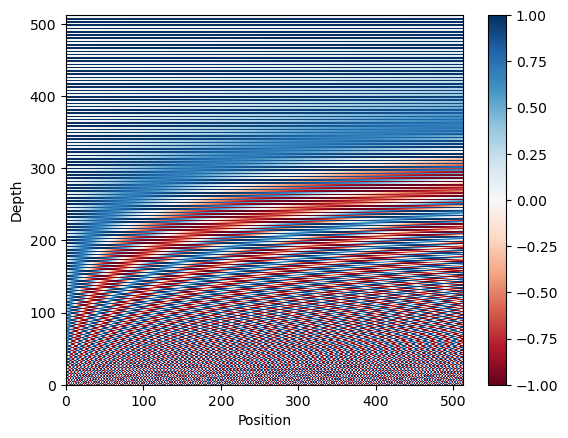

In [11]:
from matplotlib import pyplot as plt

test_pos_encoding = get_positional_encoding(max_seq_len=512, embed_dim=512)
print(test_pos_encoding[:, :None, :])

# Check the shape.
print(test_pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(test_pos_encoding[0].numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [12]:
def debug_log(x):
    tf.print("Shape:", np.shape(x))
    print("Debug:", x)
    return x

In [13]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, name, **kwargs):
        super().__init__(name=name)
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_vector, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_vector])
        return self.layernorm(x)


class SelfAttention(BaseAttention):
    def call(self, x):
        attn_vector = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_vector])
        return self.layernorm(x)


class MaskedSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask=True)
        x = self.add([x, attn_output])
        return self.layernorm(x)

In [14]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        return self.layer_norm(x)

In [15]:
from keras import layers
from archive.lib.models import graph

embed_dim = 512
max_expected_user_response = 512

position_vectors = get_positional_encoding(max_seq_len=max_expected_user_response, embed_dim=embed_dim)

model = graph.Graph(
    inputs=[
        layers.Input(shape=(inp_lang.max_timesteps,), name='english_input'),
        layers.Input(shape=(targ_lang.max_timesteps,), name='twi_input')
    ],
    layers=[
        # Encoder Positional Embedding
        layers.Embedding(name='encoder_embedding', input_dim=inp_lang.vocab_size, output_dim=embed_dim, mask_zero=True),
        layers.Lambda(name='encoder_embeddings_scaled',
                      function=lambda x: x * tf.math.sqrt(tf.cast(embed_dim, tf.float32))),
        layers.Lambda(name='encoder_positions',
                      function=lambda x: x + position_vectors[:x.shape[0], :x.shape[1], :x.shape[2]]),

        layers.Dropout(name='encoder_dropout', rate=0.1),

        SelfAttention(name="encoder_attention", num_heads=8, key_dim=embed_dim, dropout=0.1),
        FeedForward(name="encoder_feedforward", d_model=embed_dim, dff=2048),

        # Decoder Positional Embedding
        layers.Embedding(name='decoder_embedding', input_dim=targ_lang.vocab_size, output_dim=embed_dim,
                         mask_zero=True),
        layers.Lambda(name='decoder_embeddings_scaled',
                      function=lambda x: x * tf.math.sqrt(tf.cast(embed_dim, tf.float32))),
        layers.Lambda(name='decoder_positions',
                      function=lambda x: x + position_vectors[:x.shape[0], :x.shape[1], :x.shape[2]]),
        layers.Add(name='decoder_embeddings_to_positions'),

        layers.Dropout(name='decoder_dropout', rate=0.1),

        MaskedSelfAttention(name="decoder_masked_attention", num_heads=8, key_dim=embed_dim, dropout=0.1),
        CrossAttention(name="decoder_cross_attention", num_heads=8, key_dim=embed_dim, dropout=0.1),
        FeedForward(name="decoder_feedforward", d_model=embed_dim, dff=2048),

        layers.Dense(targ_lang.vocab_size, activation='softmax', name='output')
    ],
    connections=[
        # Encoder
        ('english_input', 'encoder_embedding'),
        ('encoder_embedding', 'encoder_embeddings_scaled'),
        ('encoder_embeddings_scaled', 'encoder_positions'),

        ('encoder_positions', 'encoder_dropout'),
        ('encoder_dropout', 'encoder_attention'),
        ('encoder_attention', 'encoder_feedforward'),

        # Bridge - Encoder's output goes to decoder as context
        ('encoder_feedforward', 'decoder_cross_attention[context]'),

        # Decoder
        ('twi_input', 'decoder_embedding'),
        ('decoder_embedding', 'decoder_embeddings_scaled'),
        ('decoder_embeddings_scaled', 'decoder_positions'),

        ('decoder_positions', 'decoder_dropout'),
        ('decoder_dropout', 'decoder_masked_attention'),
        ('decoder_masked_attention', 'decoder_cross_attention[x]'),
        ('decoder_cross_attention', 'decoder_feedforward'),

        ('decoder_feedforward', 'output')
    ]
)

In [16]:
model.summary()

Model: "graph"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 english_input (InputLayer)  [(None, 63)]                 0         []                            
                                                                                                  
 twi_input (InputLayer)      [(None, 70)]                 0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 63, 512)              2696704   ['english_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 decoder_embedding (Embeddi  (None, 70, 512)              3962880   ['twi_input[0][0]']       

In [17]:
# model.load_weights(checkpoint_filepath)

In [18]:
class TransformerLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

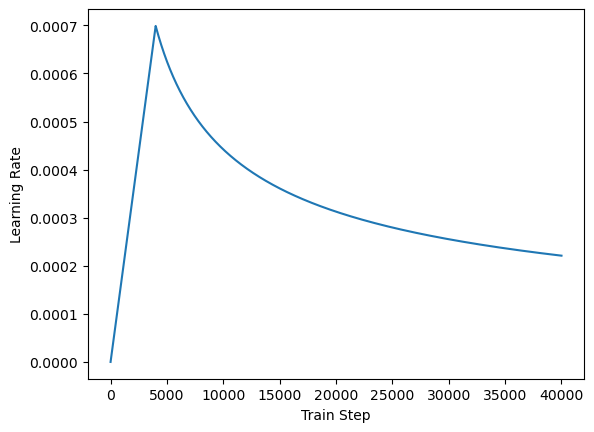

In [19]:
learning_rate = TransformerLearningRateSchedule(embed_dim)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [20]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [21]:
from keras import optimizers

model.compile(loss=masked_loss, optimizer=optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                                                 epsilon=1e-9))

In [22]:
from keras import callbacks

model_checkpoint_callback = callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True,
                                                      save_weights_only=True)

In [23]:
# data = inp_lang.tensor(), targ_lang.tensor(shift='start')
# model.fit(data, targ_lang.tensor(), epochs=10, validation_split=0.2, callbacks=[model_checkpoint_callback])

In [24]:
# model.save_weights(checkpoint_filepath)

In [25]:
from archive.lib.models.graph import Graph


class Translator(tf.Module):
    def __init__(self, transformer: Graph):
        self.transformer = transformer

    def __call__(self, sentence, max_length=60):
        output = np.array([targ_lang.eos_token])

        for i in tf.range(1, max_length):
            decoder_input = output[np.newaxis]
            predictions = self.transformer.predict([sentence, decoder_input], batch_size=1, verbose=2)
            predictions = predictions[:, -1:, :]

            predicted_id = tf.argmax(predictions, axis=-1)

            output = np.append(output, predicted_id[0], axis=0)

            print("output", output)

            if predicted_id == targ_lang.eos_token:
                break

        print(np.shape(output[0]))
        text = targ_lang[output[0].tolist()]

        return text

In [26]:
translator = Translator(model)

In [27]:
def print_translation(sentence, tokens):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens}')

In [28]:
from archive.lib.preprocessors.naive_words import naive_words

sentence = "Lion"
sentence = naive_words(sentence, punctuations="?.!,¿'", special_chars='ɛƐɔƆ').split(' ')
sentence = inp_lang.to_padded_tensor([sentence])

print_translation(sentence, translator(sentence))

1/1 - 0s - 240ms/epoch - 240ms/step
output [   0 7436]


InvalidArgumentError: Graph execution error:

Detected at node graph/decoder_positions/add defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/homebrew/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/fk/6lvr7z756yjcvwrjfwxbtl8c0000gp/T/ipykernel_42536/1624816290.py", line 7, in <module>

  File "/var/folders/fk/6lvr7z756yjcvwrjfwxbtl8c0000gp/T/ipykernel_42536/2633304717.py", line 13, in __call__

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2655, in predict

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py", line 212, in call

  File "/var/folders/fk/6lvr7z756yjcvwrjfwxbtl8c0000gp/T/ipykernel_42536/3002694192.py", line 31, in <lambda>

Incompatible shapes: [1,2,512] vs. [1,512,512]
	 [[{{node graph/decoder_positions/add}}]] [Op:__inference_predict_function_2149]

In [ ]:
np.argmax([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
preds = [
    [
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9]
    ],
    [
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9]
    ]
]
print(np.shape(preds))
arg = np.argmax(preds, axis=-1)
print(np.shape(arg))
print(arg)

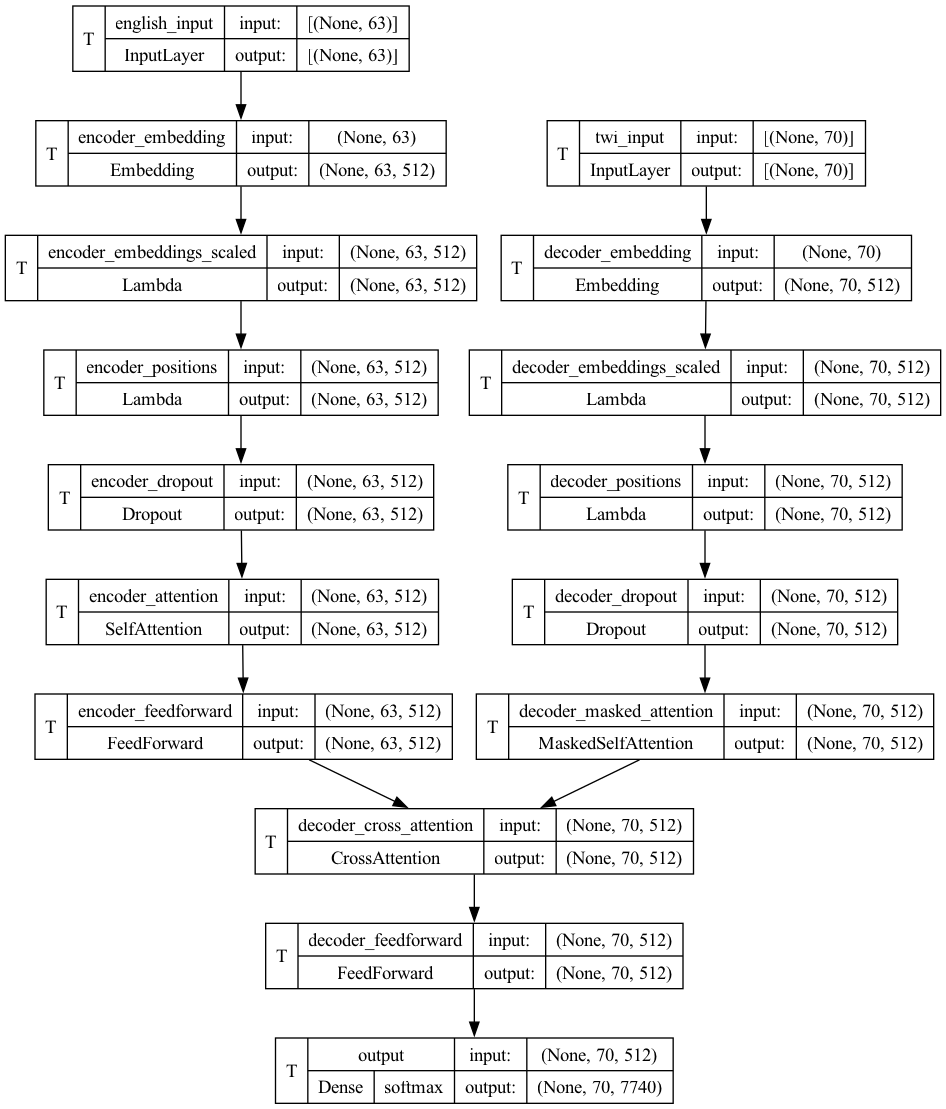

In [32]:
import keras

keras.utils.plot_model(model,
                       show_shapes=True,
                       show_layer_names=True,
                       show_dtype=False,
                       expand_nested=True,
                       show_layer_activations=True,
                       show_trainable=True
                       )